In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies, versions_key, compare_versions

In [3]:
from perfect_cookies import preprocessing, count_perfect_cookies, plot_cookies_dist
import perfect_cookies
import hard_rules

In [4]:
from tqdm import tqdm

In [5]:
sns.set(rc={'figure.figsize':(12,5)})

In [6]:
%load_ext autoreload
%autoreload 2

In [90]:
data = pd.read_parquet('../Data/10K_HH.parquet')

In [91]:
maid_chosen = "third_party"

In [402]:
df = preprocessing(data)

In [93]:
df_sorted = df.sort_values(by='time')

In [94]:
df_sorted = df_sorted[df_sorted["time"] >= pd.to_datetime("2022-12-01")]

In [95]:
df_sorted["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2022, 12)    3039691
(2023, 1)     3063579
(2023, 2)     1383089
Name: time, dtype: int64

In [96]:
two_thirds_index = int(len(df_sorted) * 2/3)

In [97]:
train = df_sorted.iloc[:two_thirds_index]
test = df_sorted.iloc[two_thirds_index:]

## Lets Predict

In [231]:
import re

In [232]:
only_relevant_maid = train[train["maid"] == perfect_cookies.maid2int(maid_chosen)]

In [233]:
pattern = re.compile(r'^\d+(\.\d+)*$')
only_relevant_maid = only_relevant_maid[only_relevant_maid.osversion.str.match(pattern)]

In [234]:
more_than_one = only_relevant_maid.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [235]:
grouped_data = more_than_one.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg(
    {'browserversion': [hard_rules.min_ver, hard_rules.max_ver], 'osversion': [hard_rules.min_ver, hard_rules.max_ver],
     'time': ['min', 'max']}).reset_index()

In [236]:
grouped_data.columns = ['hh_id', 'brand', 'model', 
                        'os', 'browser', 'advertisedbrowser', 'iiqid', 
                        'min_browser_ver', 'max_browser_ver', 
                        'min_os_ver', 'max_os_ver', 
                        'min_time', 'max_time']

In [237]:
grouped_data = grouped_data.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [264]:
grouped_ages = (end_of_time - grouped_data.groupby([
    'hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'
            ])["min_time"].max()).apply(lambda t: t.days)
print(len(grouped_ages))
print(len(grouped_data))
# grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1)

8291
24703


In [265]:
grouped_data['prev_max_time'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)
grouped_data['prev_max_browser_ver'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_browser_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)
grouped_data['prev_max_os_ver'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_os_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)

In [266]:
full_valid_rows = grouped_data[(grouped_data['min_time'] > grouped_data['prev_max_time'])
                              & (np.vectorize(compare_versions)(grouped_data['min_browser_ver'], 
                                                               grouped_data['prev_max_browser_ver']) >= 0)
                              & (np.vectorize(compare_versions)(grouped_data['min_os_ver'], 
                                                               grouped_data['prev_max_os_ver']) >= 0)]

In [354]:
end_of_time = pd.Timestamp('2023-02-24')

In [272]:
original_rows_per_hhua = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
last_cookie_age_per_hhua = (end_of_time - grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])["min_time"].max()).apply(lambda t: t.days)
valid_rows_per_hhua = full_valid_rows.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable = valid_rows_per_hhua.eq(original_rows_per_hhua)

result = pd.concat([original_rows_per_hhua, all_mergable, last_cookie_age_per_hhua], axis=1)
result.columns = ['cookies','mergeable', 'last_cookie_age'] 

In [273]:
result.head()

,,,,,,cookies,mergeable,last_cookie_age
hh_id,brand,model,os,browser,advertisedbrowser,,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False,81
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True,65
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True,62
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False,65
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False,50


### Now Lets reveal the last third a.k.a the test

In [109]:
only_relevant_maid_full = df_sorted[df_sorted["maid"] == perfect_cookies.maid2int(maid_chosen)]

In [110]:
pattern = re.compile(r'^\d+(\.\d+)*$')
only_relevant_maid_full = only_relevant_maid_full[only_relevant_maid_full.osversion.str.match(pattern)]

In [111]:
more_than_one_full = only_relevant_maid_full.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [112]:
grouped_data_full = more_than_one_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg(
    {'browserversion': [hard_rules.min_ver, hard_rules.max_ver], 'osversion': [hard_rules.min_ver, hard_rules.max_ver],
     'time': ['min', 'max']}).reset_index()

In [113]:
grouped_data_full.columns = ['hh_id', 'brand', 'model', 
                        'os', 'browser', 'advertisedbrowser', 'iiqid', 
                        'min_browser_ver', 'max_browser_ver', 
                        'min_os_ver', 'max_os_ver', 
                        'min_time', 'max_time']

In [114]:
grouped_data_full = grouped_data_full.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [115]:
grouped_data_full['prev_max_time'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)
grouped_data_full['prev_max_browser_ver'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_browser_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)
grouped_data_full['prev_max_os_ver'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_os_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)

In [116]:
full_valid_rows_full = grouped_data_full[(grouped_data_full['min_time'] > grouped_data_full['prev_max_time'])
                              & (np.vectorize(compare_versions)(grouped_data_full['min_browser_ver'], 
                                                               grouped_data_full['prev_max_browser_ver']) >= 0)
                              & (np.vectorize(compare_versions)(grouped_data_full['min_os_ver'], 
                                                               grouped_data_full['prev_max_os_ver']) >= 0)]

In [117]:
original_rows_per_hhua_full = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
valid_rows_per_hhua_full = full_valid_rows_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable_full = valid_rows_per_hhua_full.eq(original_rows_per_hhua_full)

result_full = pd.concat([original_rows_per_hhua_full, all_mergable_full], axis=1)
result_full.columns = ['cookies_full','mergeable_full'] 

In [118]:
result_full.head()

,,,,,,cookies_full,mergeable_full
hh_id,brand,model,os,browser,advertisedbrowser,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False


In [274]:
tested_train = result.join(result_full, how='left')

In [284]:
tested_train.head()

,,,,,,cookies,mergeable,last_cookie_age,cookies_full,mergeable_full
hh_id,brand,model,os,browser,advertisedbrowser,,,,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False,81,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True,65,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True,62,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False,65,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False,50,2,False


In [403]:
accuracy_by_age = tested_train.groupby('last_cookie_age').apply(lambda x: (x.loc[(x['mergeable']==True) & (x['mergeable_full']==True)].shape[0]) / x.loc[x['mergeable']==True].shape[0])

In [416]:
for i in range(min(accuracy_by_age.index), max(accuracy_by_age.index)):
    print(len(tested_train[(tested_train["last_cookie_age"]==i) & (tested_train["mergeable"]==True)]))

66
100
114
96
89
90
59
95
65
68
57
70
62
51
64
61
46
52
57
48
38
54
50
46
41
56
59
45
54
29
47
45
40
40
31
40
37
20
20
20
18
17
16
21
18
10
51
69
43
27


In [342]:
from numpy.polynomial.polynomial import polyfit

In [440]:
x = np.array(accuracy_by_age.index)
y = np.array(accuracy_by_age)

b, m = polyfit(x=accuracy_by_age.index, y=accuracy_by_age, deg=1)
coeffs = polyfit(x, y, deg=2)

In [441]:
coeffs

array([ 1.44852081e-01,  1.87593300e-02, -1.20146318e-04])

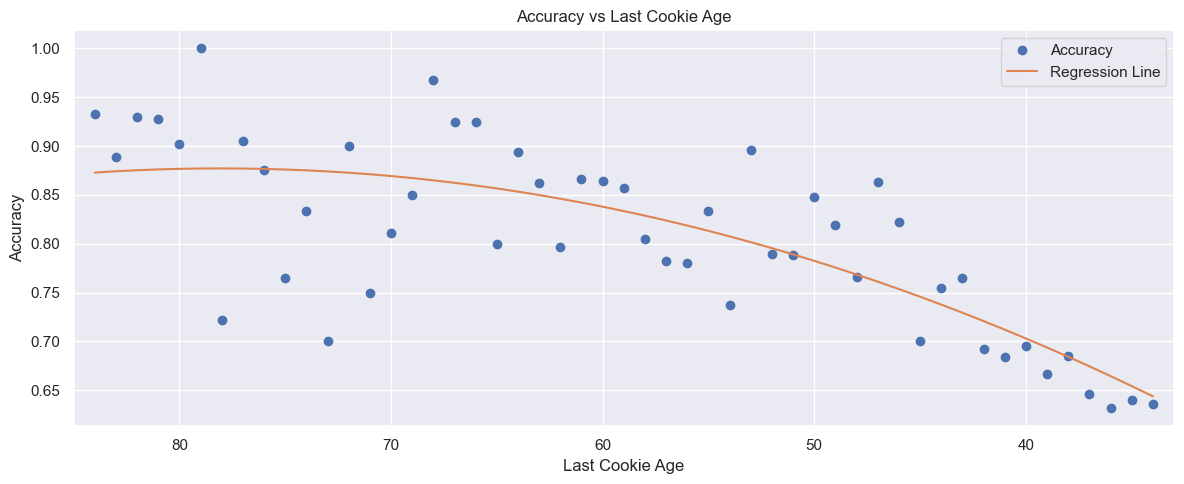

In [443]:
# plt.plot(accuracy_by_age, 'o-')
plt.plot(x, y, 'o', label='Accuracy')
plt.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line')
# plt.plot(accuracy_by_age.index, b + m * accuracy_by_age.index, '-', label='Regression Line')
plt.xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
print("How many merges didn't get ruined")
print('{:.1%}'.format((tested_train["mergeable"]==tested_train["mergeable_full"]).sum()/len(tested_train)))

How many merges didn't get ruined
93.3%


In [123]:
print("How many didn't change at all")
print('{:.1%}'.format((tested_train["cookies"]==tested_train["cookies_full"]).sum()/len(tested_train)))

How many didn't change at all
74.7%


In [128]:
print("From those who changed, how many merges didn't get ruined")
changed_total = tested_train[tested_train["cookies"]!=tested_train["cookies_full"]]
changed_but_still_ok = changed_total[changed_total["mergeable"]==changed_total["mergeable_full"]]

print('{:.1%}'.format(len(changed_but_still_ok)/len(changed_total)))

From those who changed, how many merges didn't get ruined
88.3%


### Now for every broswer

In [284]:
tested_train.head()

,,,,,,cookies,mergeable,last_cookie_age,cookies_full,mergeable_full
hh_id,brand,model,os,browser,advertisedbrowser,,,,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False,81,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True,65,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True,62,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False,65,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False,50,2,False


In [392]:
b = "chrome mobile"

In [398]:
tested_train_by_browser = tested_train.reset_index()[tested_train.reset_index()["browser"]==b]

In [399]:
accuracy_by_age_by_browser = tested_train_by_browser.groupby('last_cookie_age').apply(lambda x: (x.loc[x['mergeable'] == x['mergeable_full']].shape[0]) / x.shape[0])

In [400]:
b, m = polyfit(x=accuracy_by_age_by_browser.index, y=accuracy_by_age_by_browser, deg=1)

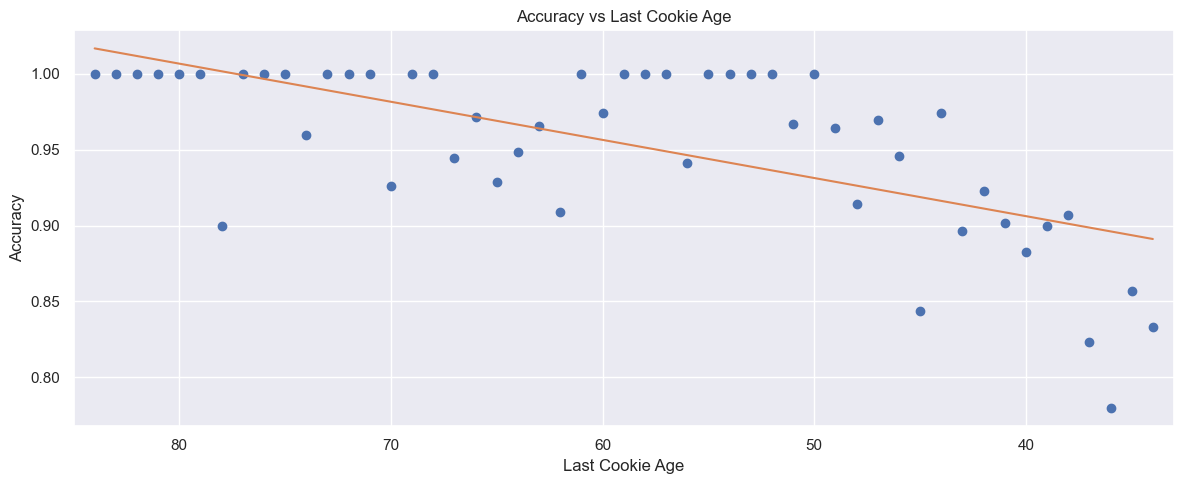

In [401]:
# plt.plot(accuracy_by_age, 'o-')
plt.plot(accuracy_by_age_by_browser.index, accuracy_by_age_by_browser, 'o')
plt.plot(accuracy_by_age_by_browser.index, b + m * accuracy_by_age_by_browser.index, '-')
plt.xlim(accuracy_by_age_by_browser.index.max()+1, accuracy_by_age_by_browser.index.min()-1)
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.tight_layout()
plt.show()

2067

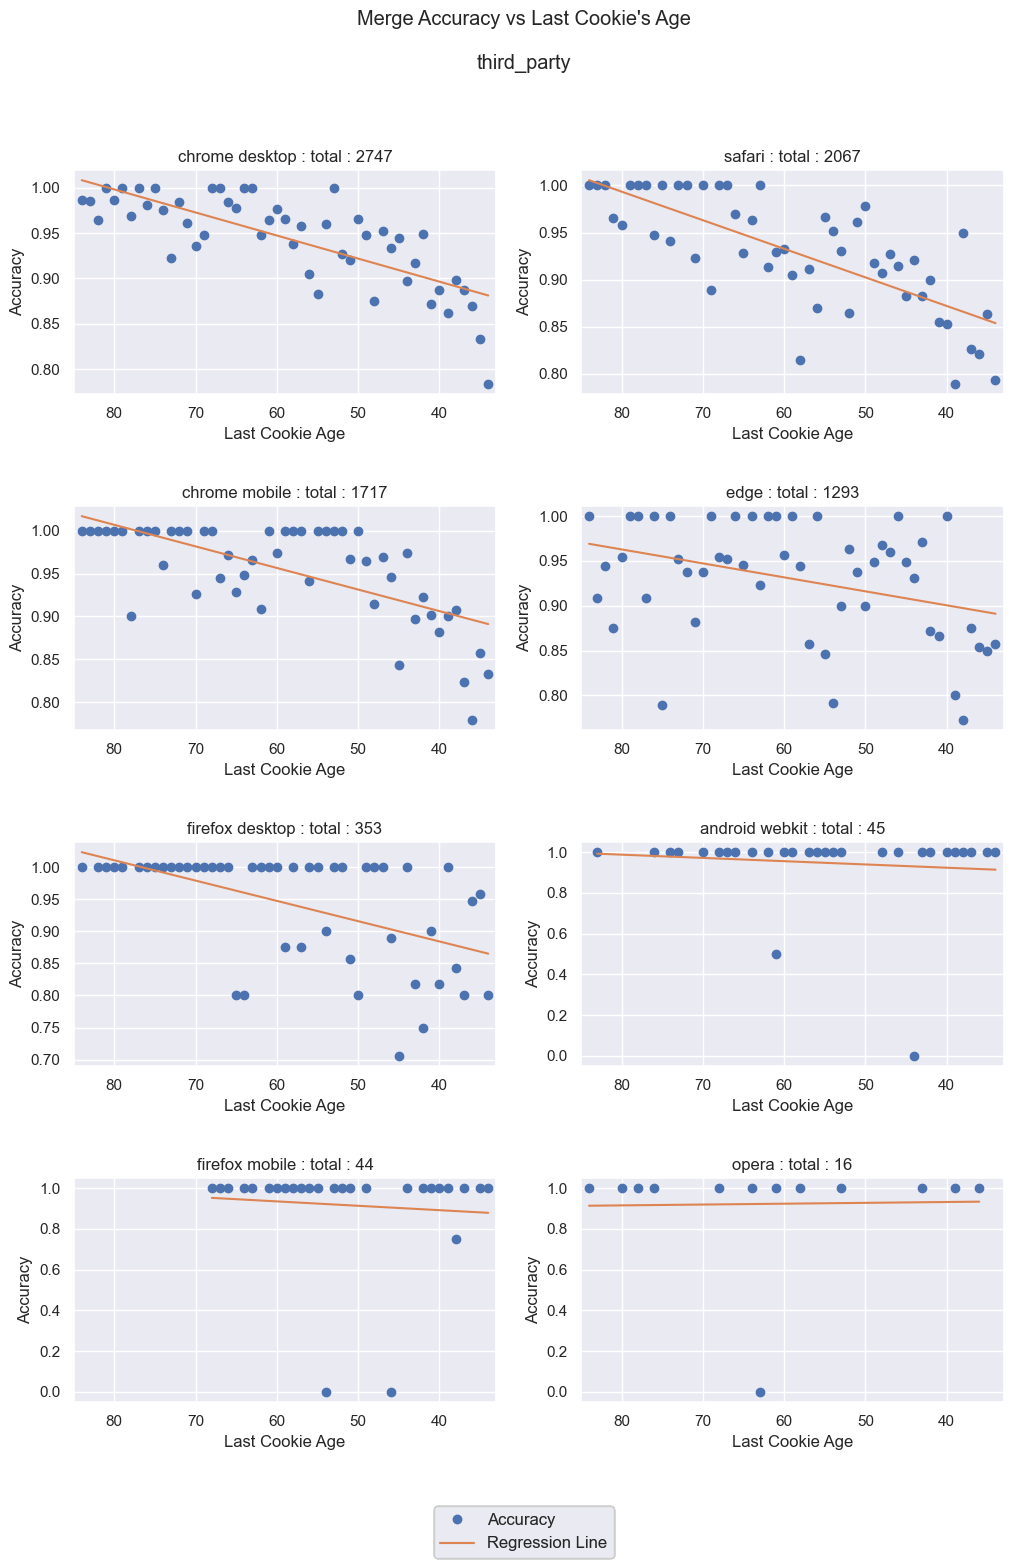

In [475]:
fig, axs = plt.subplots(nrows = 4, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(12)
plt.subplots_adjust(hspace=0.5)
fig.suptitle(f"Merge Accuracy vs Last Cookie's Age\n\n{maid_chosen}")

top_browsers = tested_train.reset_index().browser.value_counts()[:8].index

for i, b in enumerate(top_browsers):
    ax = axs.flatten()[i]
    
    tested_train_by_browser = tested_train.reset_index()[tested_train.reset_index()["browser"]==b]
    accuracy_by_age_by_browser = tested_train_by_browser.groupby('last_cookie_age').apply(lambda x: (x.loc[x['mergeable'] == x['mergeable_full']].shape[0]) / x.shape[0])
    total_count_for_browser = tested_train.reset_index().browser.value_counts().loc[b]
    
    x = np.array(accuracy_by_age_by_browser.index)
    y = np.array(accuracy_by_age_by_browser)
    coeffs = polyfit(x, y, deg=1)
    ax.plot(x, y, 'o', label='Accuracy')
    # ax.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line')
    ax.plot(x, coeffs[0] + coeffs[1] * x, '-', label='Regression Line')
    
    ax.title.set_text(f"{b} : total : {total_count_for_browser}")
    ax.set_xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)
    ax.set_xlabel('Last Cookie Age')
    ax.set_ylabel('Accuracy')
    # ax.set_title('Accuracy vs Last Cookie Age')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize='medium', bbox_to_anchor=(0.5, 0.05))    

## Scale up the data - 100K

In [7]:
data = pd.read_csv('../Data/100KHH.csv')

In [8]:
needed_columns = ['timestamp', 'filename', 'maid', 'hh_id','iiqid', 'partner_id', 'ip', 'iscellip',
       'cellispid', 'domain','is_house_ip_or_source_ip', 'brand', 'model', 'os', 'osversion',
       'browser', 'advertisedbrowser', 'browserversion', 'type', 'is_best_ip']
unnecessary_columns = [c for c in data.columns if c not in needed_columns]

In [9]:
data.drop(unnecessary_columns, axis=1, inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142712868 entries, 0 to 142712867
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   hh_id   object
dtypes: object(1)
memory usage: 1.1+ GB


In [10]:
data['time'] = pd.to_datetime(data['timestamp'], unit='ms')

KeyError: 'timestamp'

In [ ]:
data.dropna(inplace=True)

hh_id contains households id and also non-houdsehols.  
The former are strings and the later are integers.   
So we record this in a seperate cell and convert all to str  

In [ ]:
data['is_hh'] = data['hh_id'].apply(lambda x: isinstance(x, str))

In [ ]:
data.is_hh.value_counts()

In [ ]:
data['hh_id'] = data['hh_id'].astype(str)

Save the preprosecced data

In [ ]:
data.to_parquet('100KHH.parquet')

In [ ]:
# data = pd.read_parquet('../Data/10K_HH.parquet')